# Test code for evaluating the uvgap metric
 

### References:
- https://www.skatelescope.org/wp-content/uploads/2012/06/91_Figures-of-Merit-for-SKA-configuration-analysis-RevC.pdf
    - Newer definition of uvgap without gridding in the $|\mathrm{u}|$ direction
- http://www.skatelescope.org/uploaded/44041_107_Memo_Lal.pdf
    - Original uvgap reference
- http://arxiv.org/pdf/1501.01077.pdf
    - use of uvgap in analysis of simulations of IGM
- https://indico.skatelescope.org/event/262/session/2/contribution/7/material/slides/0.pdf
    - Talk on performance of SKA_1 baseline using uvgap
- https://www.skatelescope.org/wp-content/uploads/2013/08/82_Configurations-for-candidate-SKA-sites-design-and-analysis-1.0.pdf
    - Detailed analysis of array configurations for the candidate SKA sites
    - Details several figures of merit as well as results of uvgap

### Notes
- Measure of the average fractional increase in u-v length between u-v points in azimuthal wedges of the uv plane.
- Low values of UVGAP are achieved by having u-v points spread evenly in azimuth and logarithmically in radius on the u-v plane.
- Lower uvgap == better

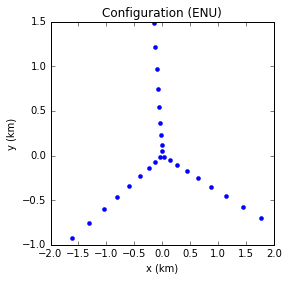

In [100]:
from __future__ import print_function, division, absolute_import
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

# FIXME(BM) these coordinates appear to be wrong... get from casa data file instead?
coords = np.loadtxt('../models/vlaC.enu.27x3.txt')
x = coords[:-1, 1]
y = coords[:-1, 2] * 0.85
z = np.zeros_like(x)

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
ax.plot(x / 1.0e3, y / 1.0e3, 'b.', ms=8.0)
ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
ax.set_title('Configuration (ENU)')
ax.plot([-2, 2.0], [1.5, 1.5], 'r--')
ax.plot([-2, 2.0], [-1.0, -1.0], 'r--')
plt.show()


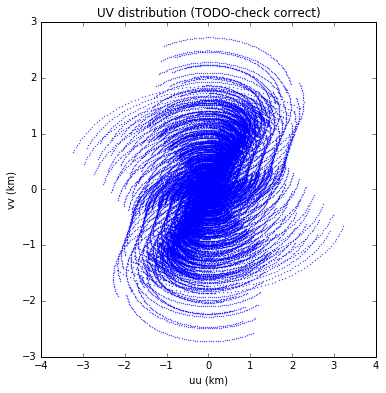

In [124]:
from pyuvwsim import (convert_enu_to_ecef, 
                      evaluate_baseline_uvw_ha_dec, 
                      datetime_to_mjd)
from math import radians

# VLA at SKA1 low site for -6, +6 HA observation, dump every 10 min
num_times = 72  # every 10 min
ha_min = -1
ha_max = +1
lon = radians(-107.6184)
lat = radians(34.0784)
dec = radians(-30.0)
x_, y_, z_ = convert_enu_to_ecef(x, y, z, lon, lat)
num_antennas = x.shape[0]
num_baselines = num_antennas * (num_antennas - 1) // 2
num_coords = num_baselines * num_times
uu = np.zeros(num_coords)
vv = np.zeros(num_coords)
ww = np.zeros(num_coords)
for i in range(num_times):
    ha = ha_min + i * ((ha_max - ha_min) / num_times)
    uu_, vv_, ww_ = evaluate_baseline_uvw_ha_dec(x_, y_, z_, ha, dec)
    uu[i * num_baselines: (i + 1) * num_baselines] = uu_
    vv[i * num_baselines: (i + 1) * num_baselines] = vv_
    ww[i * num_baselines: (i + 1) * num_baselines] = ww_

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.plot(uu / 1.0e3, vv / 1.0e3, 'b.', ms=2.0, alpha=0.5)
ax.plot(-uu / 1.0e3, -vv / 1.0e3, 'b.', ms=2.0, alpha=0.5)
ax.set_xlabel('uu (km)')
ax.set_ylabel('vv (km)')
#ax.set_xlim(-3, 3)
#ax.set_ylim(-4, 4)
ax.set_title('UV distribution (TODO-check correct)')
plt.show()


3295.1055189


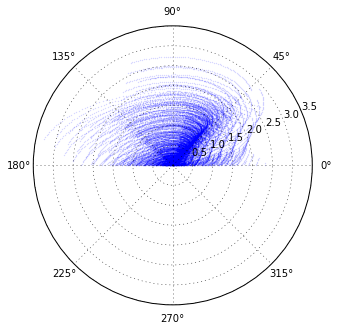

In [125]:
from math import pi

uu_ = np.copy(uu)
vv_ = np.copy(vv)
q = (uu_**2 + vv_**2)**0.5
print(q.max())
theta = np.arctan2(vv_, uu_)
theta[theta < 0.0] += pi

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, polar=True)
ax.plot(theta, q / 1.0e3, 'b.', ms=2.0, alpha=0.1)
# ax.plot(theta + pi, q / 1.0e3, 'b.', ms=2.0, alpha=0.1)
plt.show()

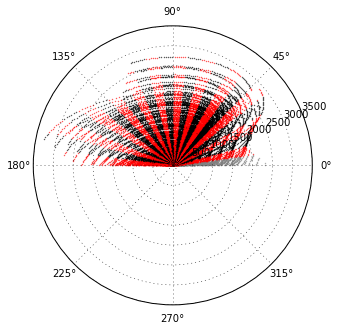

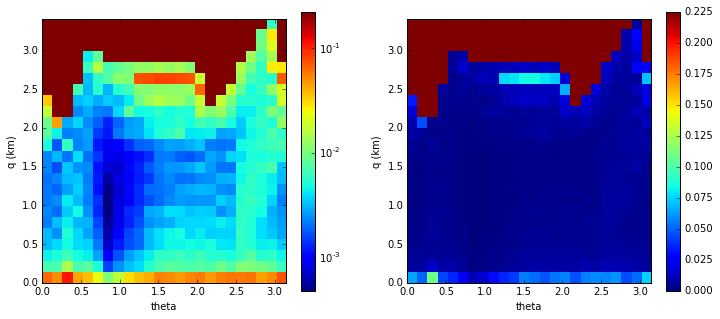

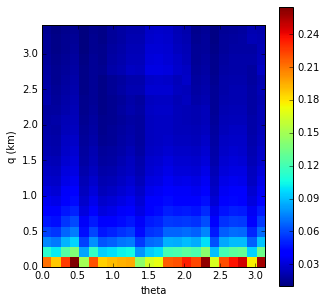

In [126]:
num_bins = 24
qmax = 3400.0  # m
theta_edges = np.linspace(0, pi, num_bins + 1)
q_edges = np.linspace(0, qmax, num_bins + 1)
theta_idx = np.digitize(theta, theta_edges)

uv_gap_im = np.zeros((num_bins, num_bins))
uv_gap_im_2 = np.zeros((num_bins, num_bins))

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, polar=True)

colors = ['k', 'r']
for j in range(num_bins):
    q_values = q[theta_idx == 1 + j]
    q_values = np.append(q_values, 0.0)
    t_values = theta[theta_idx == 1 + j]
    t_values = np.append(t_values, 0.0)
    order = np.argsort(q_values)
    q_values = q_values[order]
    t_values = t_values[order]
    ax.plot(t_values, q_values, '.', ms=2.0, alpha=0.5, 
            color=colors[j%2] if j > 0 else '0.5')
    q_diff = np.diff(q_values)
    q_diff_norm = q_diff / q_values[1:]
    
    for i in range(num_bins):
        d0 = np.where(q_values <= q_edges[i])[0][-1]
        d1 = np.where(q_values > q_edges[i + 1])[0]
        d1 = q_values.shape[0] - 1 if len(d1) == 0 else d1[0]
        bin_diffs = q_diff_norm[d0:d1]
        uv_gap_im[j, i] = numpy.nanmean(bin_diffs) \
            if bin_diffs.shape[0] > 0 else 1.0

        qmax_ = q_edges[i + 1]
        x_b = np.append(q_values, qmax_)
        x_b = np.sort(x_b)
        x_b = x_b[x_b < qmax_]
        uv_gap_im_2[j, i] = np.sum(np.diff(x_b)**2 / x_b[1:]) / qmax_
    
plt.show()    

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121)
image = np.transpose(uv_gap_im)
extent = [theta_edges[0], theta_edges[-1],
          q_edges[0]/1.0e3, q_edges[-1]/1.0e3]
im = ax.imshow(image, interpolation='nearest', 
               origin='lower', cmap='jet', extent=extent, 
               norm=LogNorm(vmax=0.225))
ax.figure.colorbar(im, ax=ax)
ax.set_xlabel('theta')
ax.set_ylabel('q (km)')

ax = fig.add_subplot(122)
image = np.transpose(uv_gap_im)
extent = [theta_edges[0], theta_edges[-1],
          q_edges[0]/1.0e3, q_edges[-1]/1.0e3]
im = ax.imshow(image, interpolation='nearest', 
               origin='lower', cmap='jet', extent=extent,
               vmin=0.0, vmax=0.225)
ax.figure.colorbar(im, ax=ax)
ax.set_xlabel('theta')
ax.set_ylabel('q (km)')
plt.show()

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
image = np.transpose(uv_gap_im_2)
extent = [theta_edges[0], theta_edges[-1],
          q_edges[0]/1.0e3, q_edges[-1]/1.0e3]
im = ax.imshow(image, interpolation='nearest', 
               origin='lower', cmap='jet', extent=extent)
ax.figure.colorbar(im, ax=ax)
ax.set_xlabel('theta')
ax.set_ylabel('q (km)')
plt.show()
